In [1]:
from fastai.vision.all import *

In [2]:
df = pd.read_csv("./data/majority_voted_annotations_class_names.csv")
# df = df.groupby('image_id')['class_id'].apply(lambda x: ','.join(set(x))).reset_index()
# df["class_name"] = df["class_name"].apply(lambda x: x.split(","))


In [20]:
row = df.loc[df['image_id'] == 'fc89fd328df2a724d19d1cb78fb97f3c']
print(row)

                               image_id      class_id
14826  fc89fd328df2a724d19d1cb78fb97f3c  Lung Opacity


In [111]:
path = "./data"

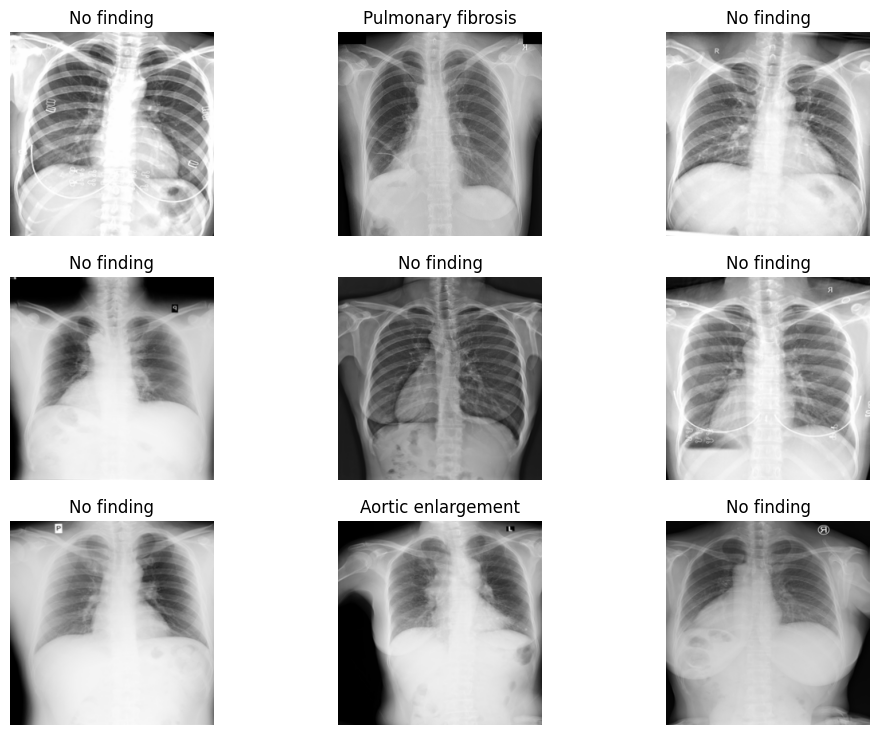

In [112]:
batch_tfms = aug_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader("image_id", pref=f'{path}/train/', suff='.png'),
                   splitter=RandomSplitter(),
                   get_y=ColReader("class_id", label_delim=','),
                   batch_tfms = batch_tfms)


dls = db.dataloaders(df)

dls.show_batch(max_n=9, figsize=(12,9))

In [113]:
dls.c

15

In [114]:
dls.vocab

['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'No finding', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']

In [115]:
from torchvision.models import resnet34
from fastai.metrics import accuracy_multi


In [116]:
learn = vision_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])


SuggestedLRs(valley=0.002511886414140463)

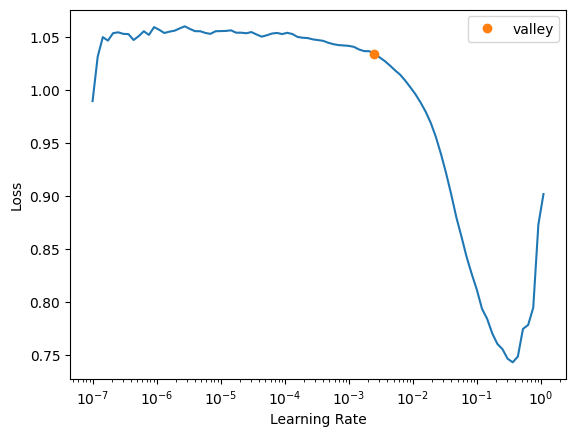

In [117]:
learn.lr_find()

In [118]:
lr = 0.003
learn = learn.to_fp16()

In [119]:
learn.fit_one_cycle(5, slice(lr))

/Users/rahulnayanegali/ai/MedXrayAI/env/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/rahulnayanegali/ai/MedXrayAI/env/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.359825,0.099203,0.970245,02:33
1,0.103904,0.085249,0.973378,02:35
2,0.091040,0.080528,0.974978,02:26
3,0.083109,0.077484,0.975489,02:20
4,0.078237,0.076283,0.975400,02:13


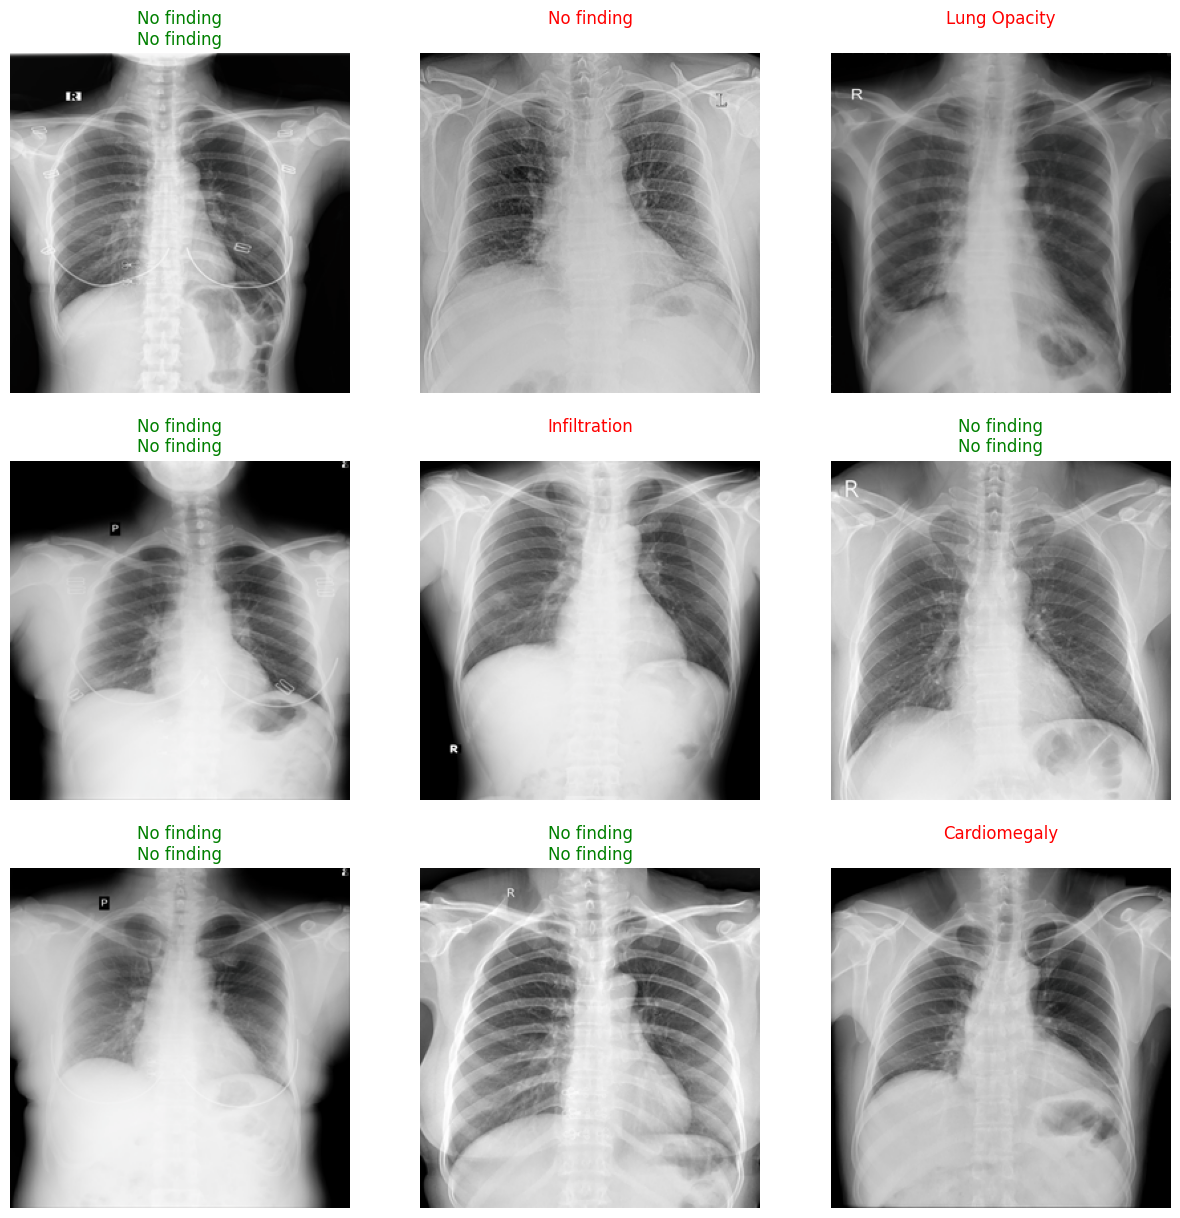

In [121]:
learn.show_results(figsize=(15,15))

In [122]:
interp = ClassificationInterpretation.from_learner(learn)

,target,predicted,probabilities,loss
0,Cardiomegaly,No finding,"tensor([1.1843e-03, 3.1242e-06, 9.2273e-05, 4.1240e-04, 5.6222e-06, 1.2228e-05,\n 6.3921e-06, 2.2116e-05, 9.9976e-01, 2.4685e-04, 7.8297e-06, 4.1144e-06,\n 1.4065e-05, 4.3240e-07, 1.5789e-05])",1.0754116773605347
1,Nodule/Mass,No finding,"tensor([1.0480e-03, 3.5686e-05, 2.7433e-05, 6.7730e-04, 1.2462e-04, 6.6150e-05,\n 3.0227e-03, 7.2527e-04, 9.9777e-01, 3.7500e-04, 1.9642e-04, 3.2300e-04,\n 4.9222e-04, 1.5630e-04, 3.1138e-03])",0.9335898160934448
2,Atelectasis,No finding,"tensor([2.0834e-02, 1.9847e-04, 7.4582e-03, 9.7073e-03, 7.6479e-05, 1.0276e-03,\n 4.5929e-04, 2.1431e-03, 8.9977e-01, 2.4695e-03, 1.1234e-03, 1.7546e-03,\n 5.8615e-03, 2.6435e-04, 3.7392e-03])",0.7254936695098877
3,Pulmonary fibrosis,No finding,"tensor([1.0513e-03, 6.6054e-05, 2.9863e-04, 1.2933e-03, 2.3977e-04, 1.3766e-04,\n 1.9730e-03, 9.7231e-04, 9.9118e-01, 2.0778e-03, 3.3777e-04, 7.6555e-04,\n 1.6794e-03, 3.7954e-04, 5.2014e-03])",0.666685938835144
4,Nodule/Mass,No finding,"tensor([1.0214e-03, 1.3211e-04, 7.0471e-04, 1.8359e-03, 4.3717e-04, 5.4537e-04,\n 7.7112e-03, 4.5459e-03, 9.6451e-01, 1.8006e-03, 1.1270e-03, 1.7778e-03,\n 5.1501e-03, 2.3365e-04, 7.5721e-03])",0.6460717916488647
5,ILD,No finding,"tensor([1.1624e-02, 4.0889e-04, 1.5751e-03, 8.9311e-03, 2.6585e-04, 2.3305e-03,\n 8.2173e-04, 3.1263e-03, 9.7098e-01, 1.3047e-03, 4.0387e-03, 5.3712e-04,\n 2.2723e-02, 1.1038e-04, 8.5438e-03])",0.6443818807601929
6,Infiltration,Aortic enlargement,"tensor([8.6040e-01, 1.6993e-04, 2.4250e-03, 1.2871e-01, 6.4195e-04, 1.6732e-03,\n 7.2581e-04, 1.5588e-02, 1.8308e-02, 6.1295e-03, 4.0470e-03, 7.3783e-03,\n 6.7960e-03, 1.5335e-04, 1.6786e-02])",0.6277048587799072
7,Infiltration,No finding,"tensor([4.6270e-03, 3.5377e-04, 2.8254e-03, 4.5369e-03, 1.5809e-04, 4.1662e-03,\n 2.5181e-03, 3.9774e-04, 9.6232e-01, 2.8729e-03, 5.3628e-04, 3.4673e-04,\n 2.2471e-02, 5.8215e-05, 1.6521e-02])",0.6215450763702393
8,ILD,No finding,"tensor([1.4291e-03, 2.2095e-04, 1.3393e-04, 2.6022e-03, 2.9973e-04, 1.3460e-03,\n 3.1255e-02, 5.6153e-03, 9.0475e-01, 4.2992e-03, 4.3201e-04, 1.6528e-02,\n 3.6209e-03, 2.4310e-04, 6.8804e-02])",0.6067050695419312
9,Infiltration,Aortic enlargement,"tensor([5.0014e-01, 4.9390e-04, 9.5137e-03, 5.7176e-02, 3.7028e-04, 8.0988e-03,\n 3.2286e-04, 2.3411e-03, 1.4809e-01, 1.4726e-02, 3.5069e-03, 5.9194e-04,\n 1.0073e-02, 8.6500e-05, 1.7753e-02])",0.6012551188468933


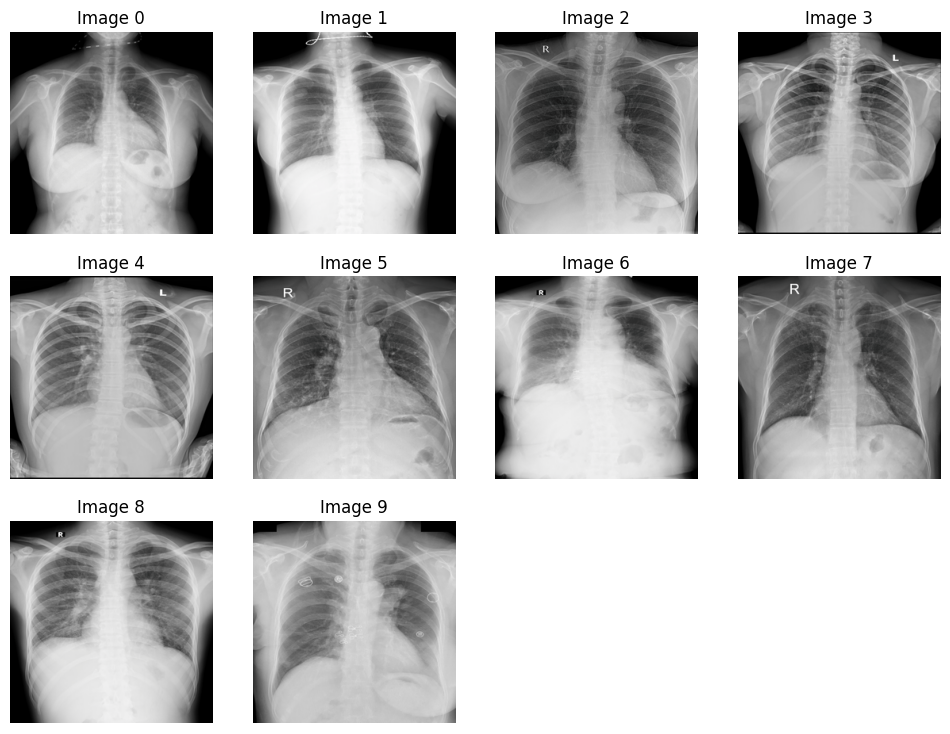

In [123]:
interp.plot_top_losses(k=10)

In [124]:
interp.most_confused()

/Users/rahulnayanegali/ai/MedXrayAI/env/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/rahulnayanegali/ai/MedXrayAI/env/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


[('Atelectasis', 'Aortic enlargement', 863),
 ('Aortic enlargement', 'Atelectasis', 244)]

In [125]:
from fastai.metrics import RocAucMulti
roc_auc = RocAucMulti(average='macro')

In [126]:
learn = vision_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi, roc_auc])

In [127]:
learn.freeze()
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,time
0,0.161230,0.091214,0.972533,0.781415,02:20


In [128]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,time
0,0.087214,0.080511,0.975978,0.870970,03:29
1,0.070176,0.071304,0.976911,0.890150,03:18
2,0.063261,0.058717,0.981022,0.915110,03:06
3,0.054325,0.058645,0.980489,0.922378,03:06
4,0.044960,0.054094,0.982067,0.928431,03:06


In [129]:
# Saving the model
learn.export("trained_model.pkl")


In [130]:
# Testing
import pandas as pd

In [133]:
# Load the trained model
model = load_learner("trained_model.pkl")

# Load your new untrained image
new_image_path = "nodal_mass.png"

# Preprocess the new image
img = PILImage.create(new_image_path)

# Make predictions
preds, _, _ = model.predict(img)

# Display predictions
print(model.predict(img))

(['No finding'], tensor([False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False]), tensor([8.5662e-02, 2.3602e-03, 5.4150e-02, 1.1513e-02, 1.5734e-03, 2.5615e-01,
        7.7634e-04, 3.0793e-03, 6.6654e-01, 5.8953e-03, 1.7145e-02, 1.2303e-03,
        4.8830e-03, 8.8105e-05, 4.6313e-03]))
